In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from tqdm import tqdm
import warnings
import joblib
warnings.filterwarnings('ignore')

In [2]:
# Função para extrair características de áudio
def extract_features(audio_data, sample_rate, mfcc=True, chroma=True, mel=True, spectral_centroid=True, zero_crossing_rate=True):
        features = []
        
        # Calcular a média da amplitude do sinal de áudio
        amplitude_mean = np.mean(np.abs(audio_data))
        features.append(amplitude_mean)
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            features.extend(mfccs)
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(y=audio_data, sr=sample_rate).T,axis=0)
            features.extend(chroma)
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T,axis=0)
            features.extend(mel)
        if spectral_centroid:
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)[0])
            features.append(spectral_centroid)
        if zero_crossing_rate:
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_data))
            features.append(zero_crossing_rate)
            
        return features

# Diretório onde os arquivos de áudio estão localizados
audio_dir = "MP3"

# Lista para armazenar as características extraídas
features = []

# Lista para armazenar os nomes dos arquivos de áudio válidos
audio_files = []

# Extrair características de cada arquivo de áudio na pasta
for file_name in os.listdir(audio_dir):
    if file_name.endswith(".mp3"):
        # Carregar o áudio usando librosa
        audio_data, sample_rate = librosa.load(os.path.join(audio_dir, file_name))

        # Extrair características do áudio
        features.append(extract_features(audio_data, sample_rate))


# Convertendo a lista de características para uma matriz numpy
features = np.array(features)
print(features)

[[ 2.82559656e-02 -3.57475494e+02  1.44278671e+02 ...  4.16022249e-06
   1.50232086e+03  6.08282574e-02]
 [ 5.79456165e-02 -3.62867981e+02  1.13480652e+02 ...  2.81965913e-06
   1.84096022e+03  8.56782699e-02]
 [ 1.74287818e-02 -3.74741486e+02  1.28402176e+02 ...  2.24341238e-06
   1.87077334e+03  7.87385360e-02]
 ...
 [ 1.11866057e-01 -1.49723373e+02  1.98960831e+02 ...  2.88329873e-04
   1.10294515e+03  6.74756512e-02]
 [ 3.38188857e-02 -2.22196304e+02  1.61071274e+02 ...  9.62356808e-06
   1.43517457e+03  9.27903451e-02]
 [ 1.43012881e-01 -1.48891693e+02  1.65103821e+02 ...  9.46412270e-04
   1.43657138e+03  6.68424881e-02]]


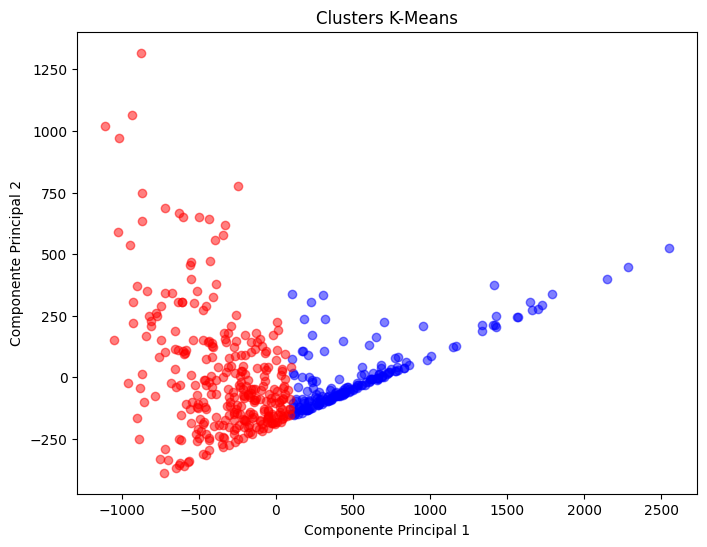

Método não supervisionado:
Acurácia : 0.44693877551020406
F1 Score: 0.440167145687585


In [3]:
# MÉTODO NÃO SUPERVISIONADO (K-MEANS)
# Aplicar K-Means para agrupar os dados
kmeans = KMeans(n_clusters=2)  
kmeans.fit(features)

# Rotular os clusters
labels = kmeans.labels_

# Identificar os arquivos de áudio que são identificados como áudios válidos
audio_files_indices = np.where(labels == 1)[0]

# Exibir os arquivos de áudio que são identificados como outliers
# print("Deglutições detectadas nos seguintes arquivos (K-Means):")
# for idx in audio_files_indices:
#     audio_files.append(os.path.join(audio_dir, os.listdir(audio_dir)[idx]))
#     print(os.listdir(audio_dir)[idx])

# Aplicar PCA para reduzir a dimensionalidade dos dados para visualização
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Plotar os clusters
plt.figure(figsize=(8, 6))
for i in range(len(features_pca)):
    if labels[i] == 0:
        plt.scatter(features_pca[i, 0], features_pca[i, 1], color='blue', alpha=0.5)
    else:
        plt.scatter(features_pca[i, 0], features_pca[i, 1], color='red', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters K-Means')
plt.show()

# Identificando true labels
tutor = pd.read_csv('classificacao_anomalias.csv')
tutor = tutor[['File Name','Label']]
tutor['Label'] = tutor['Label'].apply(lambda x: 1 if x == 0 else 0)
true_labels = tutor['Label'].values

# Calcular a acurácia
accuracy = accuracy_score(true_labels, labels)

# Calcular a pontuação F1
f1 = f1_score(true_labels, labels, average='weighted')

# Printando Acurácia e F1 Score
print("Método não supervisionado:")
print("Acurácia :", accuracy)
print("F1 Score:", f1)

In [4]:
# Comparando classificadores de aprendizado supervisionado com validação cruzada
classificadores = [
    DecisionTreeClassifier(random_state=42,max_depth=5),
    ExtraTreeClassifier(random_state=42,max_depth=5),
    RandomForestClassifier(random_state=42,max_depth=5),
    ExtraTreesClassifier(random_state=42,max_depth=5),
    GradientBoostingClassifier(random_state=42,max_depth=5),
    AdaBoostClassifier(random_state=42),
    HistGradientBoostingClassifier(random_state=42,max_depth=5),
    LogisticRegression(random_state=42),
]

resultados = []
for cls in tqdm(classificadores):
    res = cross_validate(cls, features, true_labels, cv=5, scoring='f1')
    resultados.append(
        {'metodo': cls.__class__.__name__, 
         'f1': res['test_score'].mean(), 
         'tempo': res['fit_time'].mean(),
         }
    )

warnings.filterwarnings('default')
df_res = pd.DataFrame(resultados)
df_res.sort_values('f1', ascending=False)
print(df_res)

# MÉTODO SUPERVISIONADO (Random Forest Classifier)
# Instanciar um objeto RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42, max_depth=5)

# Ajustar o modelo aos dados de treinamento
random_forest.fit(features, true_labels)

# Salvar o modelo
joblib.dump(random_forest, 'RandomForestClassifier.joblib')

# F1 Score do modelo
f1_rfc = random_forest.score(features, true_labels)

print("\nMétodo supervisionado:")
print("F1 Score:", f1_rfc)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:09<00:00,  8.66s/it]


                           metodo        f1      tempo
0          DecisionTreeClassifier  0.497981   0.086369
1             ExtraTreeClassifier  0.597540   0.001198
2          RandomForestClassifier  0.561205   0.631897
3            ExtraTreesClassifier  0.572033   0.106527
4      GradientBoostingClassifier  0.451193  11.221779
5              AdaBoostClassifier  0.512648   1.270014
6  HistGradientBoostingClassifier  0.455892   0.458972
7              LogisticRegression  0.473741   0.025579

Método supervisionado:
F1 Score: 0.8551020408163266


In [5]:
# Diretório onde os testes de áudio estão localizados
audio_dir = "test"

# Lista para armazenar as características extraídas
features_test = []

# Extrair características de cada arquivo de áudio na pasta
for file_name in os.listdir(audio_dir):
    if file_name.endswith(".mp3"):
        # Carregar o áudio usando librosa
        audio_data, sample_rate = librosa.load(os.path.join(audio_dir, file_name))

        # Extrair características do áudio
        features_test.append(extract_features(audio_data, sample_rate))


In [6]:
# Identificando true labels dos testes
tutor_test = pd.read_csv('classificacao_testes.csv')
tutor_test = tutor_test[['File Name','Label']]
true_labels_test = tutor_test['Label'].values

# Carregar o modelo treinado
classificador = joblib.load('RandomForestClassifier.joblib')

# Prever os rótulos dos testes
y_pred = classificador.predict(features_test)

# Calcular a acurácia
print(classification_report(true_labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.40      0.33      0.36         6

    accuracy                           0.42        12
   macro avg       0.41      0.42      0.41        12
weighted avg       0.41      0.42      0.41        12



In [10]:
# Lista de boas deglutições
audios_list = ['a00028.mp3','a00073.mp3','a00083.mp3','a00111.mp3','a00112.mp3','a00115.mp3','a00133.mp3','a00180.mp3','a00183.mp3','a00376.mp3','a00393.mp3','a00397.mp3','a00443.mp3']

audio_dir = 'MP3'

# Seprando em janelas de 0.5s com passo de 0.25s para analisar os áudios
dados = []
for file_name in os.listdir(audio_dir):
    if file_name in audios_list:
        audio_data, sample_rate = librosa.load(os.path.join(audio_dir, file_name))
        x = np.arange(len(audio_data))/sample_rate

        janela = int(0.5 * sample_rate)
        passo = int(0.25 * sample_rate)

        linha = []
        for i in range(0, len(audio_data), int(passo)):
            max = i + janela
            if max > len(audio_data):
                break
            linha.append((x[i:max], audio_data[i:max]))    
        dados.append(linha)

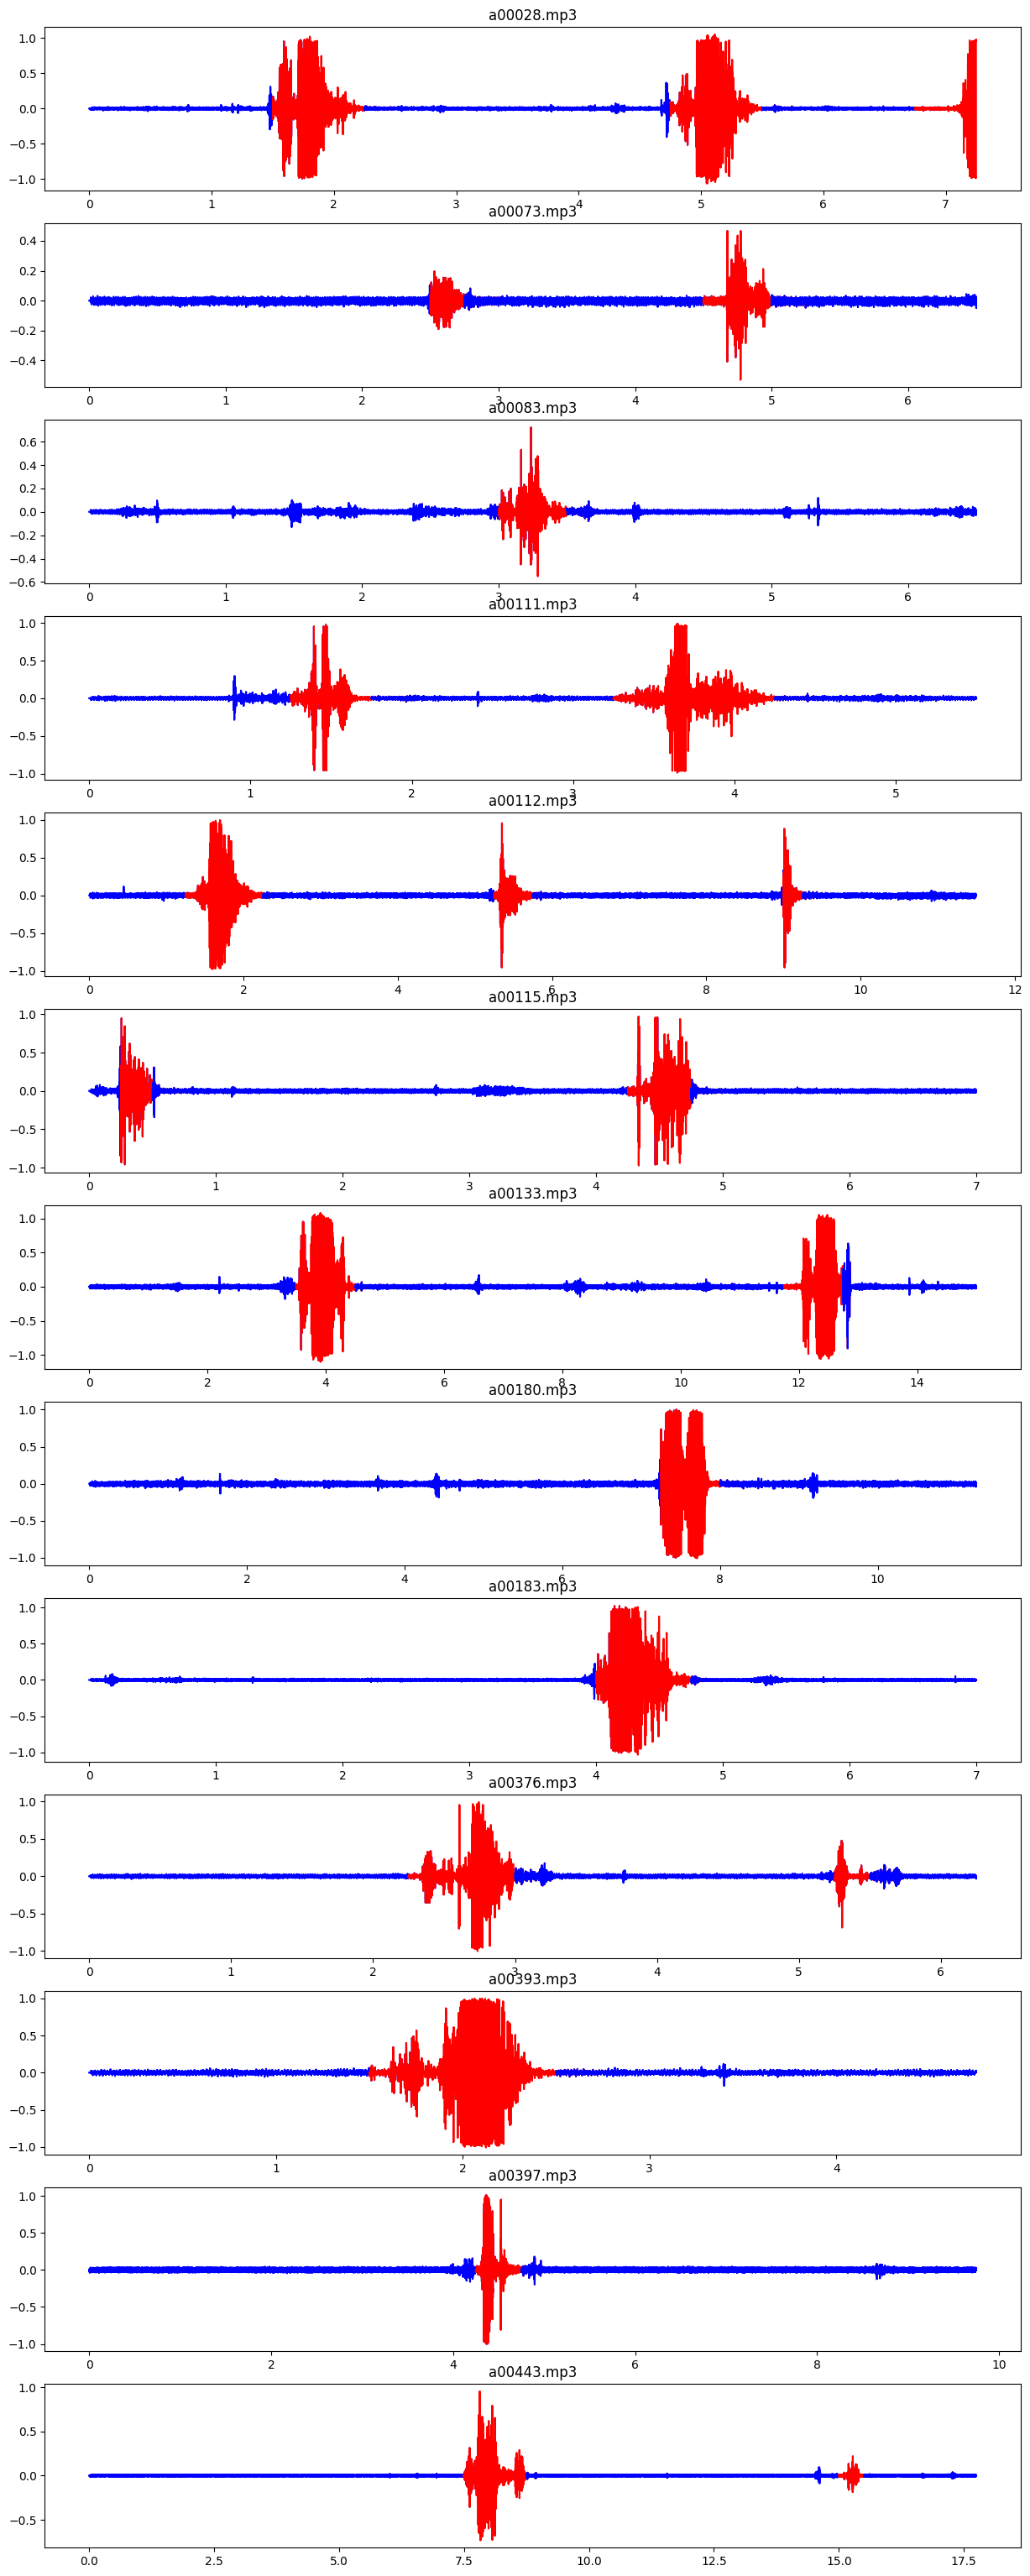

In [11]:
# Dados de treinamento
X = []
for i, linha in enumerate(dados):
    for _, y in linha:
        X.append(y)

# Rótulos para cada janela de áudio
df_y = pd.read_csv('classificacao_janelas.csv')
df_y = df_y.drop('File Name', axis=1)
y = df_y.values
y = np.ravel(np.array(y))
y = y[~np.isnan(y)]

# Classificador Random Forest
clf = RandomForestClassifier(random_state=42, max_depth=5)

# Treinando o classificador com os dados de áudio
clf.fit(X, y)

# Previsões sobre os dados de áudio
ano = clf.predict(X)
ano = (ano == 1)

# Plotando os resultados
fig, ax = plt.subplots(len(dados), 1, figsize=(15, 3*len(dados)))
n=-1
for i, linha in enumerate(dados):
    ax[i].set_title(audios_list[i])
    for x, y in linha:
        n+=1
        ax[i].plot(x, y, color='red' if ano[n] else 'blue')
plt.show()

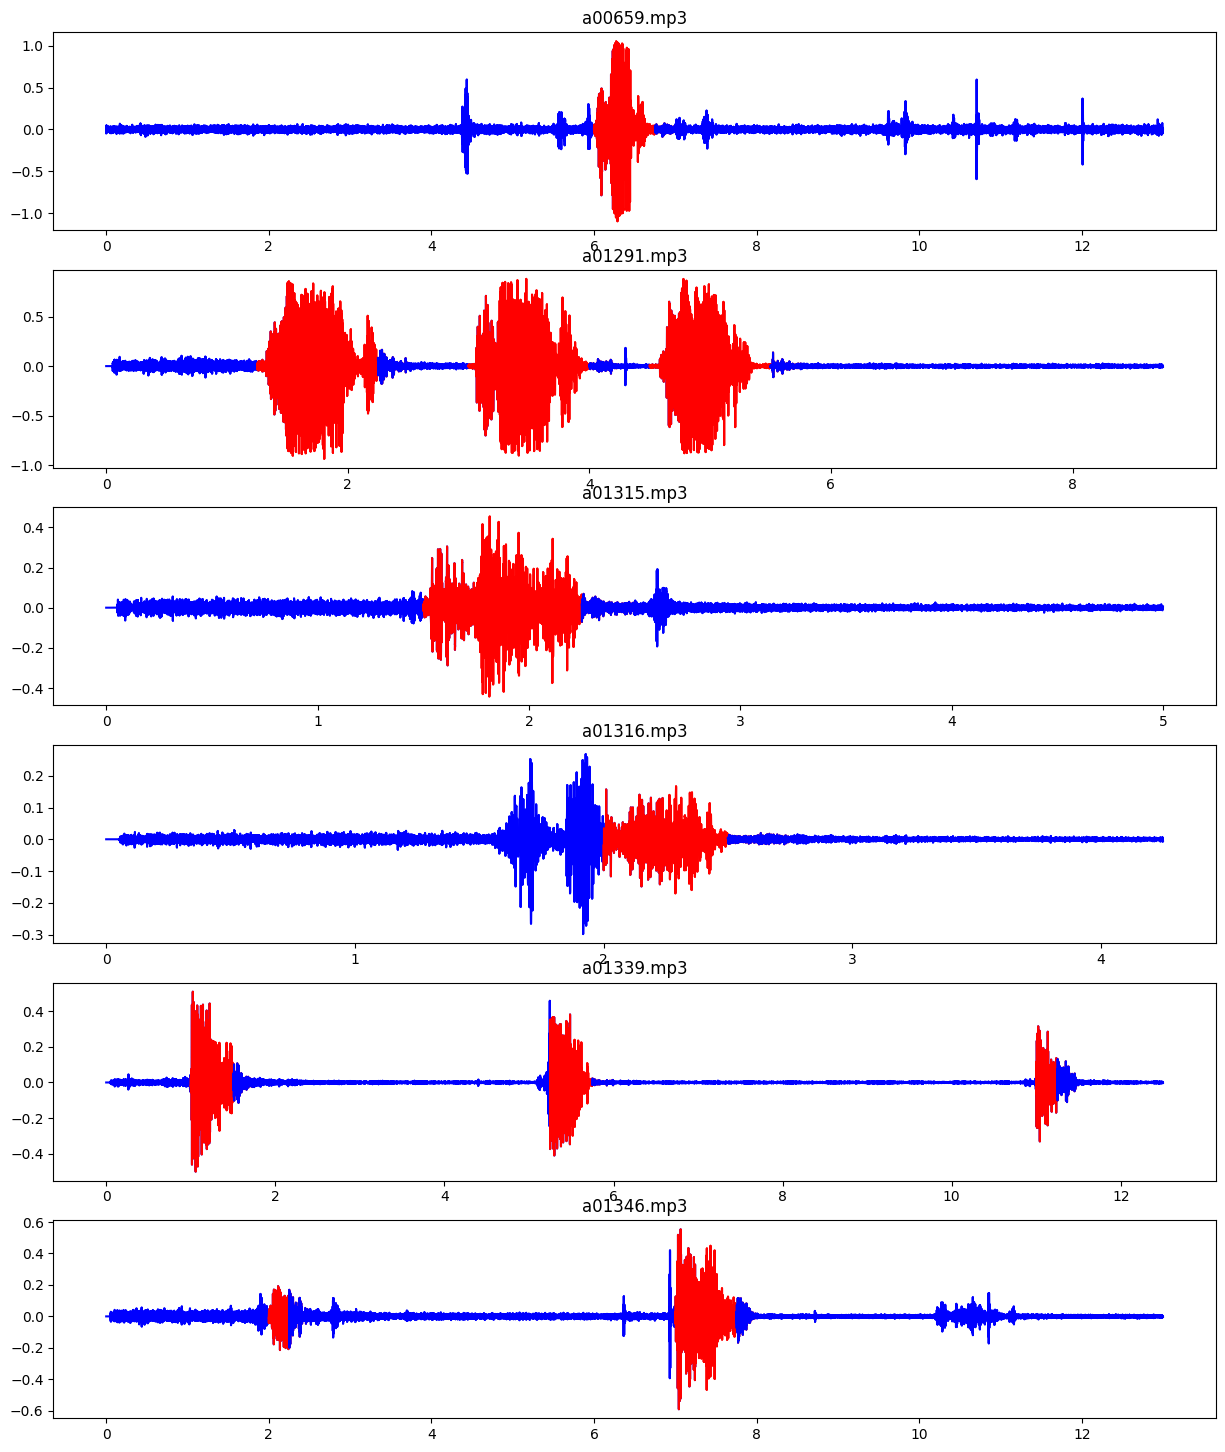

In [12]:
# Áudios válidos para teste
audios_list = ['a00659.mp3', 'a01291.mp3', 'a01315.mp3', 'a01316.mp3', 'a01339.mp3', 'a01346.mp3']

audio_dir = 'test'

# Seprando em janelas de 0.5s com passo de 0.25s para analisar os áudios para testes
dados = []
for file_name in os.listdir(audio_dir):
    if file_name in audios_list:
        audio_data, sample_rate = librosa.load(os.path.join(audio_dir, file_name))
        x = np.arange(len(audio_data))/sample_rate

        janela = int(0.5 * sample_rate)
        passo = int(0.25 * sample_rate)

        linha = []
        for i in range(0, len(audio_data), int(passo)):
            max = i + janela
            if max > len(audio_data):
                break
            linha.append((x[i:max], audio_data[i:max]))    
        dados.append(linha)

# Dados de teste
X_test = []
for i, linha in enumerate(dados):
    for _, y in linha:
        X_test.append(y)

# Previsões sobre os dados de áudio
ano = clf.predict(X_test)
ano = (ano == 1)

# Plotando os resultados
fig, ax = plt.subplots(len(dados), 1, figsize=(15, 3*len(dados)))
n=-1
for i, linha in enumerate(dados):
    ax[i].set_title(audios_list[i])
    for x, y in linha:
        n+=1
        ax[i].plot(x, y, color='red' if ano[n] else 'blue')
plt.show()